In [1]:
import tensorflow as tf

In [2]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [3]:
class Conv2D(tf.keras.layers.Conv2D):
    def __init__(self,f,k,a,b,**kwdarg):
        super().__init__(
            filters=f,
            kernel_size=k,
            activation=a,
            use_bias=b,
            strides=1,
            padding='valid',
            **kwdarg)
    def call(self,inp,training):
        x = super().call(inp)
        return x

In [4]:
class DepthwiseConv2D(tf.keras.layers.DepthwiseConv2D):
    def __init__(self,m,k,a,b,**kwdarg):
        super().__init__(
            depth_multiplier=m,
            kernel_size=k,
            activation=a,
            use_bias=b,
            strides=1,
            padding='valid',
            **kwdarg)
    def call(self,inp,training):
        x = super().call(inp)
        return x

In [5]:
class DepthControl(tf.keras.layers.Layer):
    def __init__(self,r,a,b):
        super().__init__()
        self.r = 2**r
        self.a = a
        self.b = b
    def build(self,input_shape):
        self.conv = Conv2D(
            f=int(input_shape[-1]*self.r),
            k=1,
            a=self.a,
            b=self.b)
    def call(self,inp,training):
        x = self.conv(inp,training=training)
        return x

In [6]:
class DownSample(tf.keras.layers.Layer):
    def __init__(self,k=(2,2)):
        super().__init__()
        self.k = k
    def build(self,input_shape):
        self.output_size = (input_shape[1]//self.k[0],input_shape[2]//self.k[1])
    def call(self,inp,training):
        return tf.image.resize(inp, self.output_size)

In [7]:
class Contract(tf.keras.layers.Layer):
    def __init__(self,k):
        super().__init__()
        self.downsample = DownSample(k)
        self.increase = DepthControl(r=1,a=None,b=False)
    def call(self,inp,training):
        x = self.downsample(inp,training=training)
        x = self.increase(x,training=training)
        return x

In [8]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.block1 = tf.keras.Sequential([
            DepthwiseConv2D(m=32,k=3,a=None,b=False),
            Conv2D(f=32,k=3,a=mish,b=True),
            Contract((1,2))
        ])
        self.block2 = tf.keras.Sequential([
            Conv2D(f=64,k=3,a=mish,b=True),
            Contract((1,2))
        ])
        self.block3 = tf.keras.Sequential([
            Conv2D(f=128,k=3,a=mish,b=True),
            Contract((1,2))
        ])
        self.block4 = tf.keras.Sequential([
            Conv2D(f=256,k=3,a=mish,b=True),
            Contract((2,2))
        ])
        self.block5 = tf.keras.Sequential([
            Conv2D(f=512,k=2,a=mish,b=True),
            Contract((1,2))
        ])
        self.block6 = tf.keras.Sequential([
            Conv2D(f=512,k=3,a=mish,b=True),
            Conv2D(f=512,k=3,a=mish,b=True),
            Conv2D(f=512,k=2,a=mish,b=True)
        ])
        self.output_layer = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1024,activation=mish,use_bias=True),
            tf.keras.layers.Dense(512,activation=mish,use_bias=True),
            tf.keras.layers.Dense(256,activation=mish,use_bias=True),
            tf.keras.layers.Dense(128,activation=mish,use_bias=True),
            tf.keras.layers.Dense(64,activation=mish,use_bias=True),
            tf.keras.layers.Dense(32,activation=mish,use_bias=True),
            tf.keras.layers.Dense(16,activation=mish,use_bias=True),
            tf.keras.layers.Dense(4,activation=mish,use_bias=True),
            tf.keras.layers.Dense(1,activation='sigmoid',use_bias=False),
        ])
        
    def call(self,image,training):
        x = self.block1(image,training=training)
        x = self.block2(x,training=training)
        x = self.block3(x,training=training)
        x = self.block4(x,training=training)
        x = self.block5(x,training=training)
        x = self.block6(x,training=training)
        x = self.output_layer(x,training=training)
        return x
    
    def predict(self,image):
        predict = self(image,training=False)
        predict = tf.squeeze(predict,axis=-1)
        predict = predict.numpy()
        predict = predict > 0.5
        return predict

In [9]:
model = Model()

In [10]:
import FLAGS

FLAGS.MODEL = model
FLAGS.IMAGE_SHAPE = (40,240)

FLAGS.TRAIN.RECORD_WEIGHTS_PATH = r'D:\DL_competition_Dataset\ChinaSteel\overtrun_detect_model_weights\model_2\trial_1'
FLAGS.TRAIN.LABEL_SMOOTHING = 0
FLAGS.TRAIN.OPTIMIZER.TYPE = tf.keras.optimizers.Adam
FLAGS.TRAIN.OPTIMIZER.MAX_LR = 0.5 * 1e-3
FLAGS.TRAIN.EPOCH.TOTAL = 100
FLAGS.TRAIN.EPOCH.WARMUP = 5

FLAGS.DATA.TRAIN.PATH = r'D:\DL_competition_Dataset\ChinaSteel\dataset\custom\overturn_sep'
FLAGS.DATA.TRAIN.TRAIN_BATCH_SIZE = 32
FLAGS.DATA.TRAIN.VALIDATION_RATIO = 0.05
FLAGS.DATA.TRAIN.VALIDATION_BATCH_SIZE = 32
FLAGS.DATA.TEST.IMAGE_PATH = r'D:\DL_competition_Dataset\ChinaSteel\dataset\custom\segment\test'
FLAGS.DATA.TEST.BATCH_SIZE = 8

STEP:    100 TRAIN loss BCE: 0.69315, Accuracy 0.44949
STEP:    200 TRAIN loss BCE: 0.69313, Accuracy 0.55292
STEP:    300 TRAIN loss BCE: 0.69280, Accuracy 0.61622
==================== EPOCH: 0 ====================
VALIDATION loss BCE: 0.52433, Accuracy 0.79592
False


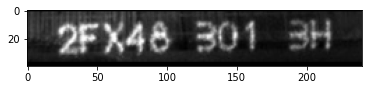

False


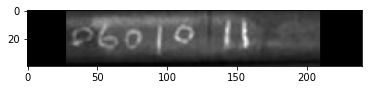

True


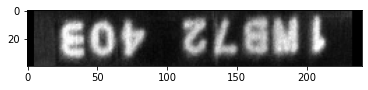

False


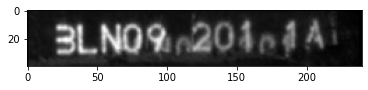

False


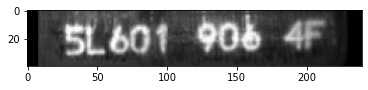

False


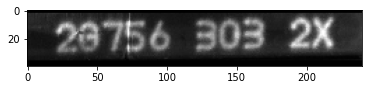

False


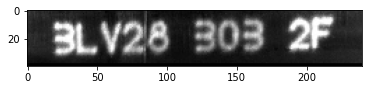

False


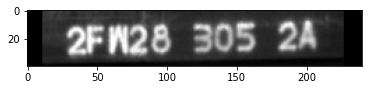

STEP:    400 TRAIN loss BCE: 0.41163, Accuracy 0.83333
STEP:    500 TRAIN loss BCE: 0.41782, Accuracy 0.81502
STEP:    600 TRAIN loss BCE: 0.39580, Accuracy 0.82799
STEP:    700 TRAIN loss BCE: 0.36048, Accuracy 0.84693
==================== EPOCH: 1 ====================
VALIDATION loss BCE: 0.15061, Accuracy 0.95503
False


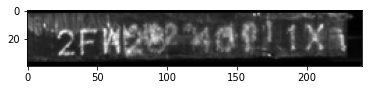

False


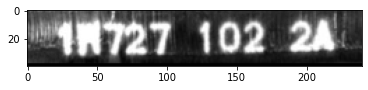

False


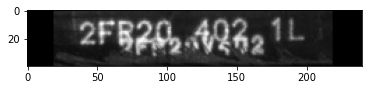

False


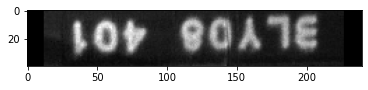

False


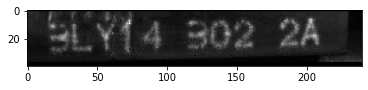

True


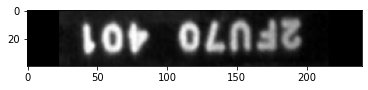

False


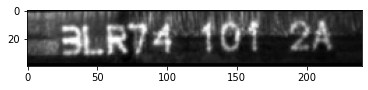

False


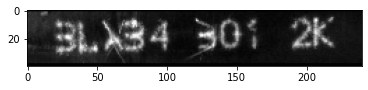

STEP:    800 TRAIN loss BCE: 0.17481, Accuracy 0.93941
STEP:    900 TRAIN loss BCE: 0.15086, Accuracy 0.94715
STEP:   1000 TRAIN loss BCE: 0.15001, Accuracy 0.94654
STEP:   1100 TRAIN loss BCE: 0.14213, Accuracy 0.95075
==================== EPOCH: 2 ====================
VALIDATION loss BCE: 0.09439, Accuracy 0.97534
False


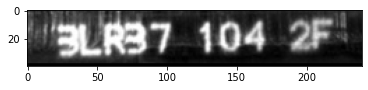

False


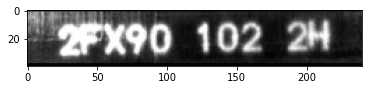

True


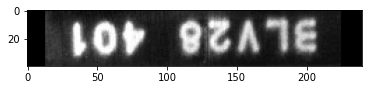

False


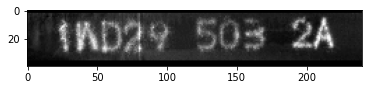

False


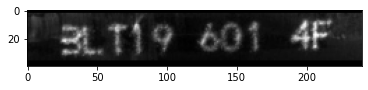

False


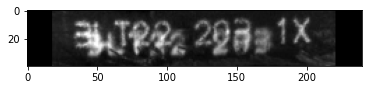

False


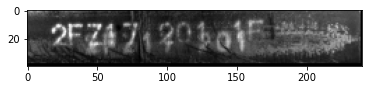

False


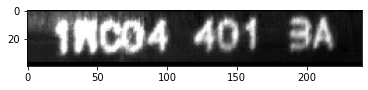

STEP:   1200 TRAIN loss BCE: 0.11711, Accuracy 0.96073
STEP:   1300 TRAIN loss BCE: 0.11451, Accuracy 0.96336
STEP:   1400 TRAIN loss BCE: 0.11388, Accuracy 0.96396
STEP:   1500 TRAIN loss BCE: 0.11427, Accuracy 0.96516
==================== EPOCH: 3 ====================
VALIDATION loss BCE: 0.06409, Accuracy 0.98438
True


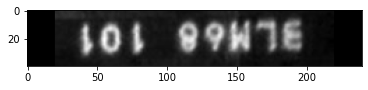

True


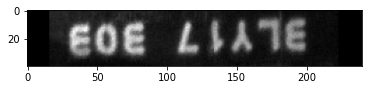

True


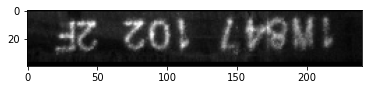

False


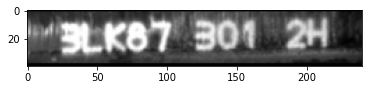

True


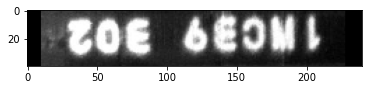

False


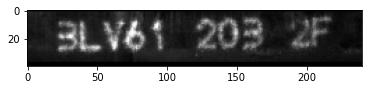

False


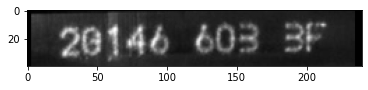

False


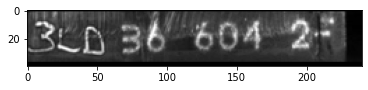

STEP:   1600 TRAIN loss BCE: 0.09326, Accuracy 0.97001
STEP:   1700 TRAIN loss BCE: 0.09315, Accuracy 0.97173
STEP:   1800 TRAIN loss BCE: 0.09132, Accuracy 0.97324
==================== EPOCH: 4 ====================
VALIDATION loss BCE: 0.09163, Accuracy 0.96094
False


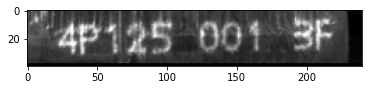

False


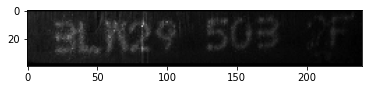

True


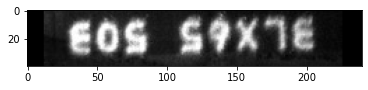

False


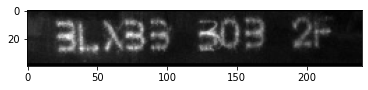

False


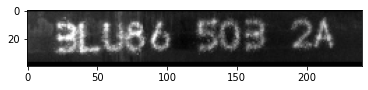

False


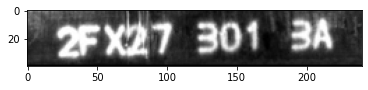

True


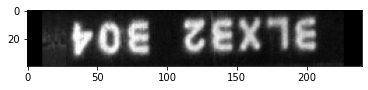

True


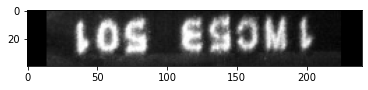

STEP:   1900 TRAIN loss BCE: 0.07680, Accuracy 0.98307
STEP:   2000 TRAIN loss BCE: 0.08003, Accuracy 0.97833
STEP:   2100 TRAIN loss BCE: 0.08670, Accuracy 0.97600
STEP:   2200 TRAIN loss BCE: 0.08346, Accuracy 0.97647
==================== EPOCH: 5 ====================
VALIDATION loss BCE: 0.06438, Accuracy 0.98281
False


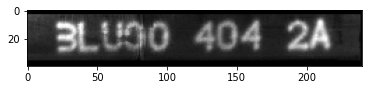

False


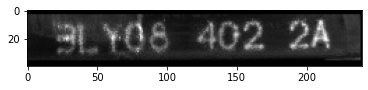

True


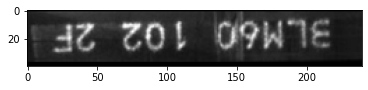

False


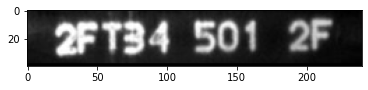

False


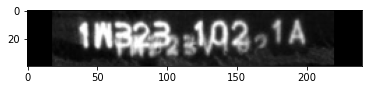

False


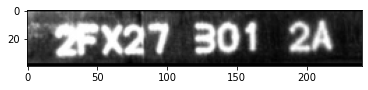

False


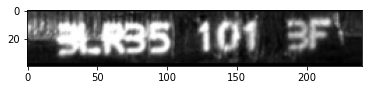

False


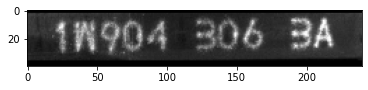

STEP:   2300 TRAIN loss BCE: 0.05853, Accuracy 0.98469
STEP:   2400 TRAIN loss BCE: 0.07313, Accuracy 0.98070
STEP:   2500 TRAIN loss BCE: 0.07824, Accuracy 0.97866
STEP:   2600 TRAIN loss BCE: 0.07770, Accuracy 0.97842
==================== EPOCH: 6 ====================
VALIDATION loss BCE: 0.04492, Accuracy 0.99158
True


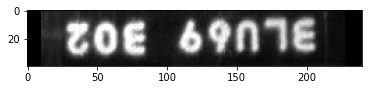

False


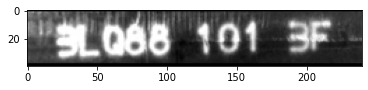

False


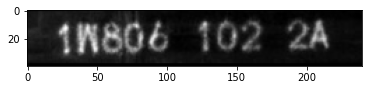

False


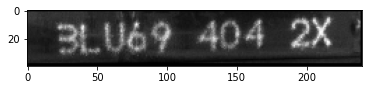

True


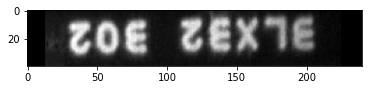

True


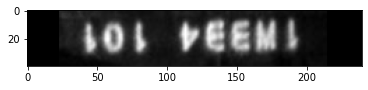

True


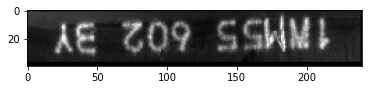

False


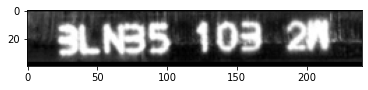

STEP:   2700 TRAIN loss BCE: 0.06505, Accuracy 0.98269
STEP:   2800 TRAIN loss BCE: 0.07043, Accuracy 0.98024
STEP:   2900 TRAIN loss BCE: 0.07106, Accuracy 0.98038
STEP:   3000 TRAIN loss BCE: 0.07285, Accuracy 0.97953
==================== EPOCH: 7 ====================
VALIDATION loss BCE: 0.04633, Accuracy 0.99219
True


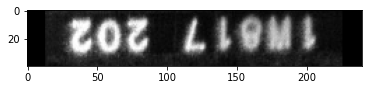

False


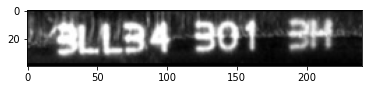

False


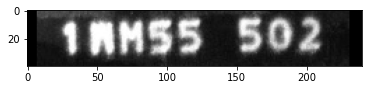

False


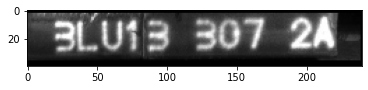

True


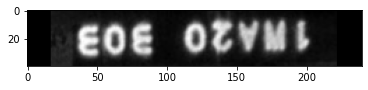

False


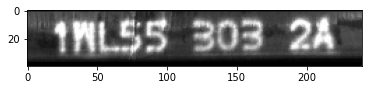

False


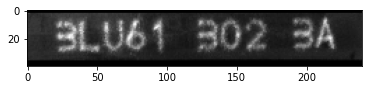

True


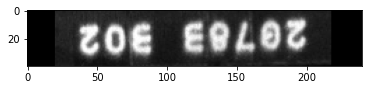

STEP:   3100 TRAIN loss BCE: 0.07180, Accuracy 0.98295
STEP:   3200 TRAIN loss BCE: 0.07234, Accuracy 0.98241
STEP:   3300 TRAIN loss BCE: 0.06756, Accuracy 0.98328
==================== EPOCH: 8 ====================
VALIDATION loss BCE: 0.04676, Accuracy 0.99219
False


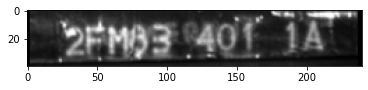

False


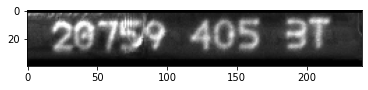

True


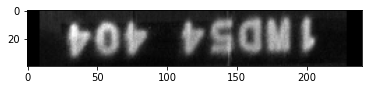

False


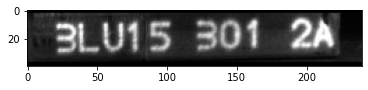

False


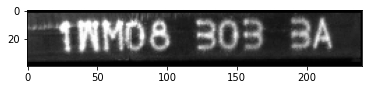

False


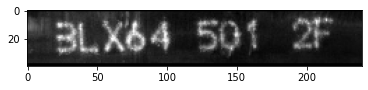

True


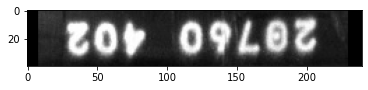

True


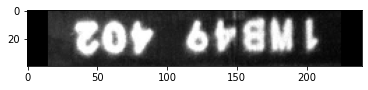

STEP:   3400 TRAIN loss BCE: 0.06315, Accuracy 0.98177
STEP:   3500 TRAIN loss BCE: 0.07220, Accuracy 0.98085
STEP:   3600 TRAIN loss BCE: 0.06835, Accuracy 0.98242
STEP:   3700 TRAIN loss BCE: 0.06532, Accuracy 0.98331
==================== EPOCH: 9 ====================
VALIDATION loss BCE: 0.04018, Accuracy 0.99219
False


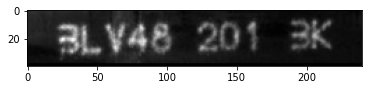

False


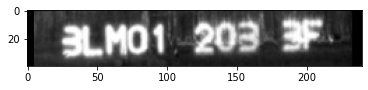

False


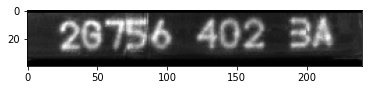

False


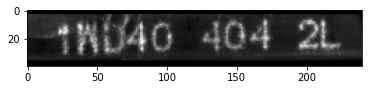

True


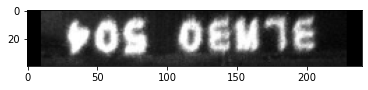

False


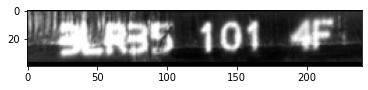

True


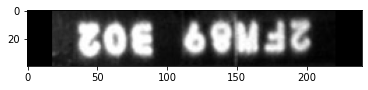

True


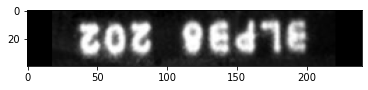

STEP:   3800 TRAIN loss BCE: 0.06735, Accuracy 0.98278
STEP:   3900 TRAIN loss BCE: 0.06358, Accuracy 0.98385
STEP:   4000 TRAIN loss BCE: 0.06362, Accuracy 0.98356
STEP:   4100 TRAIN loss BCE: 0.06396, Accuracy 0.98352
==================== EPOCH: 10 ====================
VALIDATION loss BCE: 0.04389, Accuracy 0.99219
False


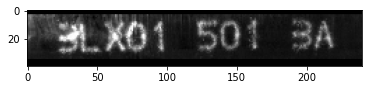

False


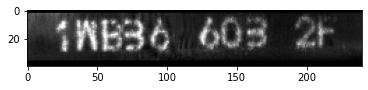

False


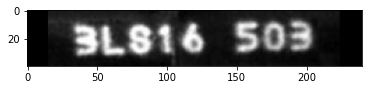

False


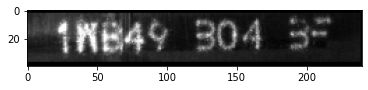

True


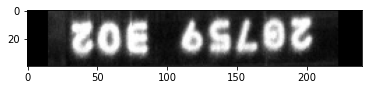

False


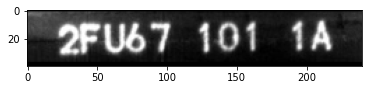

False


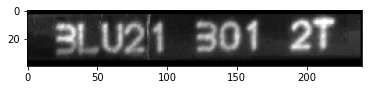

True


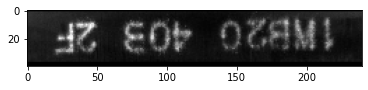

STEP:   4200 TRAIN loss BCE: 0.05950, Accuracy 0.98226
STEP:   4300 TRAIN loss BCE: 0.05664, Accuracy 0.98563
STEP:   4400 TRAIN loss BCE: 0.06073, Accuracy 0.98540
STEP:   4500 TRAIN loss BCE: 0.06294, Accuracy 0.98463
==================== EPOCH: 11 ====================
VALIDATION loss BCE: 0.06306, Accuracy 0.98438
False


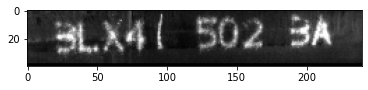

True


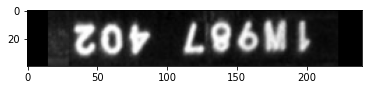

True


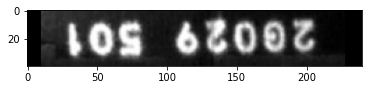

False


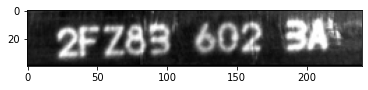

True


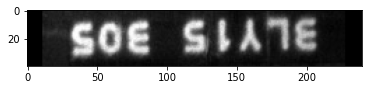

False


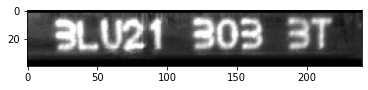

False


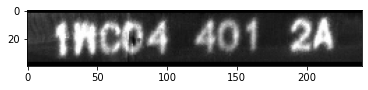

False


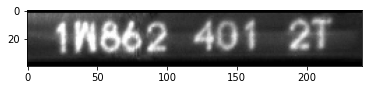

STEP:   4600 TRAIN loss BCE: 0.06013, Accuracy 0.98453
STEP:   4700 TRAIN loss BCE: 0.06096, Accuracy 0.98508
STEP:   4800 TRAIN loss BCE: 0.06507, Accuracy 0.98359
==================== EPOCH: 12 ====================
VALIDATION loss BCE: 0.03961, Accuracy 0.99219
False


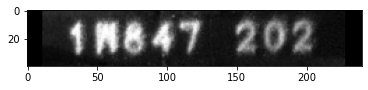

True


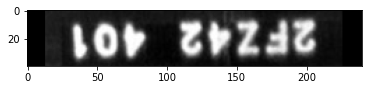

False


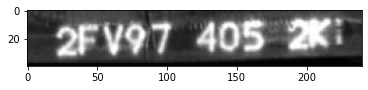

False


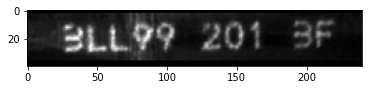

False


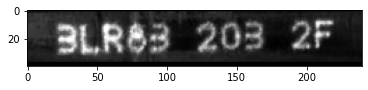

False


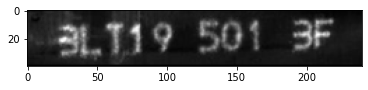

False


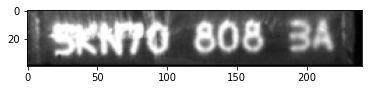

False


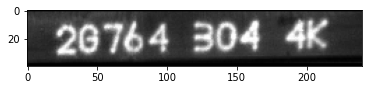

STEP:   4900 TRAIN loss BCE: 0.04002, Accuracy 0.98958
STEP:   5000 TRAIN loss BCE: 0.05338, Accuracy 0.98790
STEP:   5100 TRAIN loss BCE: 0.06292, Accuracy 0.98410
STEP:   5200 TRAIN loss BCE: 0.06289, Accuracy 0.98457
==================== EPOCH: 13 ====================
VALIDATION loss BCE: 0.04255, Accuracy 0.99219
False


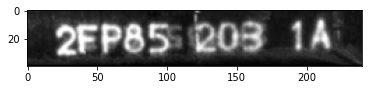

False


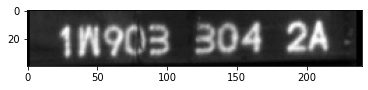

False


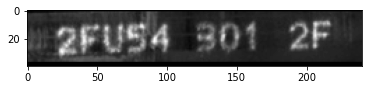

False


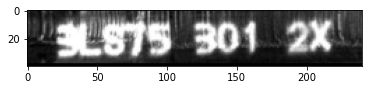

True


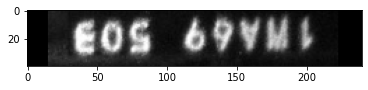

False


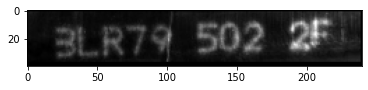

False


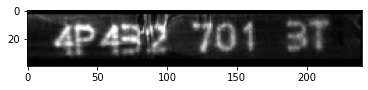

False


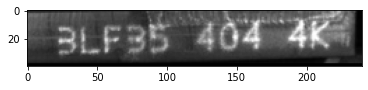

STEP:   5300 TRAIN loss BCE: 0.06083, Accuracy 0.98852
STEP:   5400 TRAIN loss BCE: 0.06644, Accuracy 0.98427
STEP:   5500 TRAIN loss BCE: 0.06323, Accuracy 0.98444
STEP:   5600 TRAIN loss BCE: 0.05976, Accuracy 0.98505
==================== EPOCH: 14 ====================
VALIDATION loss BCE: 0.04288, Accuracy 0.99375
False


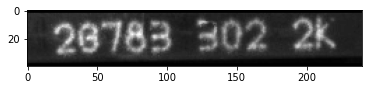

False


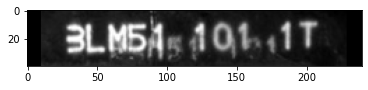

False


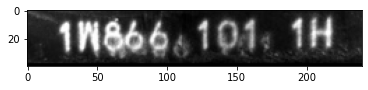

True


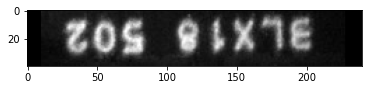

False


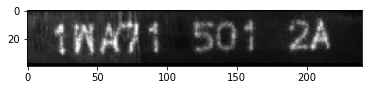

False


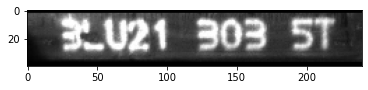

True


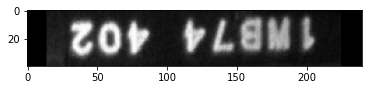

True


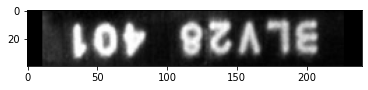

STEP:   5700 TRAIN loss BCE: 0.05800, Accuracy 0.98649
STEP:   5800 TRAIN loss BCE: 0.06058, Accuracy 0.98509
STEP:   5900 TRAIN loss BCE: 0.06160, Accuracy 0.98460
STEP:   6000 TRAIN loss BCE: 0.06254, Accuracy 0.98412
==================== EPOCH: 15 ====================
VALIDATION loss BCE: 0.03358, Accuracy 0.99375
False


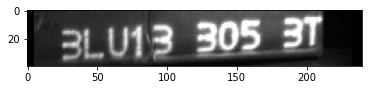

False


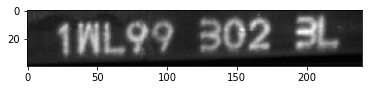

True


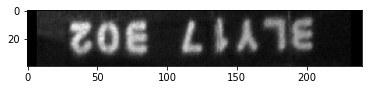

False


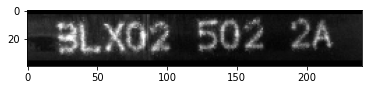

False


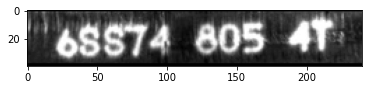

False


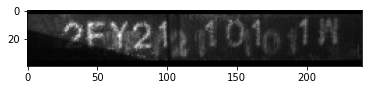

False


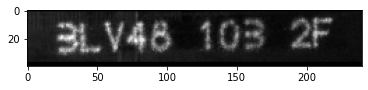

False


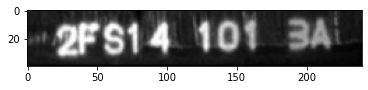

STEP:   6100 TRAIN loss BCE: 0.05228, Accuracy 0.98769
STEP:   6200 TRAIN loss BCE: 0.05505, Accuracy 0.98555
STEP:   6300 TRAIN loss BCE: 0.05353, Accuracy 0.98662
==================== EPOCH: 16 ====================
VALIDATION loss BCE: 0.04902, Accuracy 0.98750
True


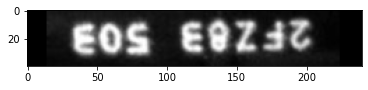

True


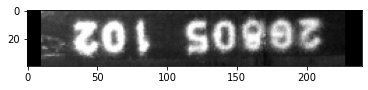

True


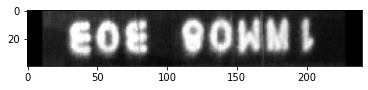

False


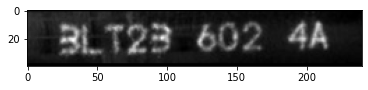

False


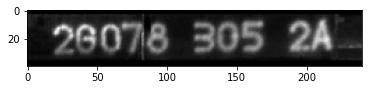

False


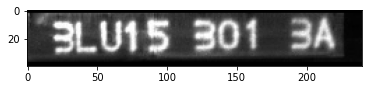

True


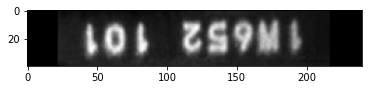

False


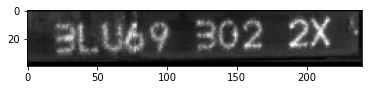

STEP:   6400 TRAIN loss BCE: 0.06497, Accuracy 0.98307
STEP:   6500 TRAIN loss BCE: 0.05966, Accuracy 0.98664
STEP:   6600 TRAIN loss BCE: 0.05846, Accuracy 0.98619
STEP:   6700 TRAIN loss BCE: 0.05914, Accuracy 0.98573
==================== EPOCH: 17 ====================
VALIDATION loss BCE: 0.04262, Accuracy 0.98845
False


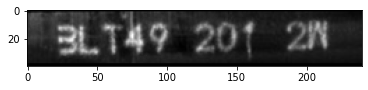

False


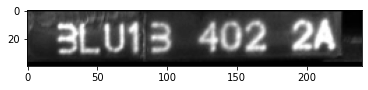

False


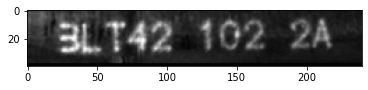

False


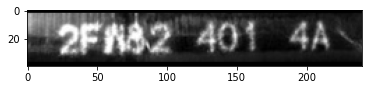

False


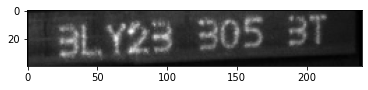

False


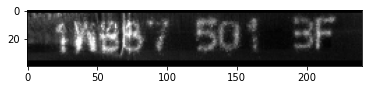

False


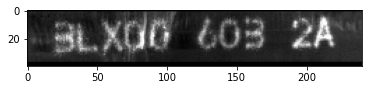

False


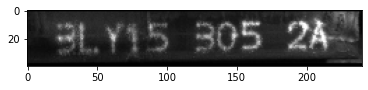

STEP:   6800 TRAIN loss BCE: 0.04847, Accuracy 0.98852
STEP:   6900 TRAIN loss BCE: 0.04888, Accuracy 0.98888
STEP:   7000 TRAIN loss BCE: 0.05080, Accuracy 0.98808
STEP:   7100 TRAIN loss BCE: 0.05567, Accuracy 0.98666
==================== EPOCH: 18 ====================
VALIDATION loss BCE: 0.03762, Accuracy 0.99219
True


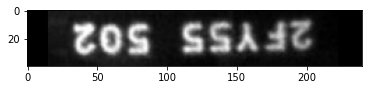

False


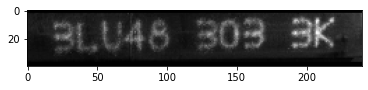

True


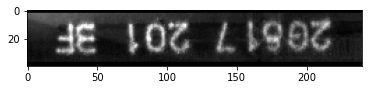

False


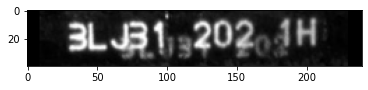

True


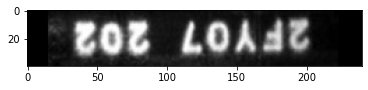

False


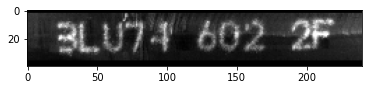

True


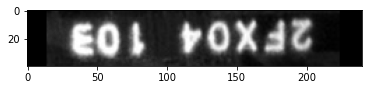

True


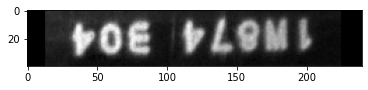

STEP:   7200 TRAIN loss BCE: 0.03933, Accuracy 0.98944
STEP:   7300 TRAIN loss BCE: 0.04865, Accuracy 0.98635
STEP:   7400 TRAIN loss BCE: 0.05353, Accuracy 0.98597
STEP:   7500 TRAIN loss BCE: 0.05675, Accuracy 0.98546
==================== EPOCH: 19 ====================
VALIDATION loss BCE: 0.03900, Accuracy 0.99063
False


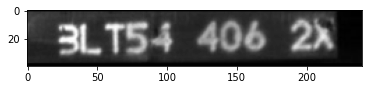

False


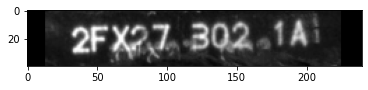

False


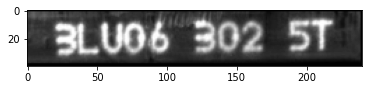

False


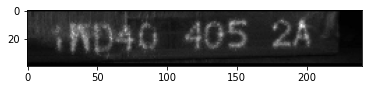

False


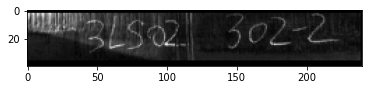

False


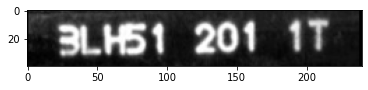

True


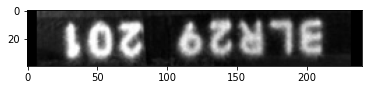

False


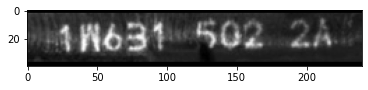

STEP:   7600 TRAIN loss BCE: 0.07136, Accuracy 0.98390
STEP:   7700 TRAIN loss BCE: 0.06220, Accuracy 0.98540
STEP:   7800 TRAIN loss BCE: 0.05837, Accuracy 0.98631
==================== EPOCH: 20 ====================
VALIDATION loss BCE: 0.03847, Accuracy 0.99063
False


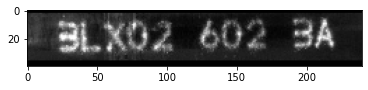

True


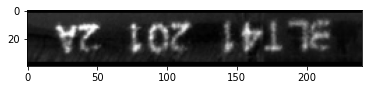

False


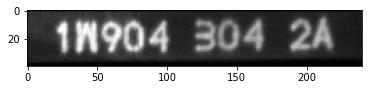

True


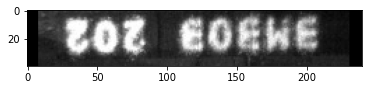

True


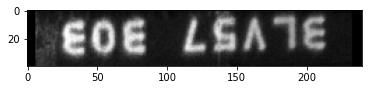

False


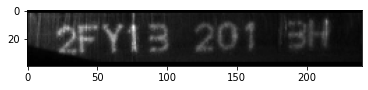

False


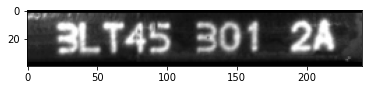

False


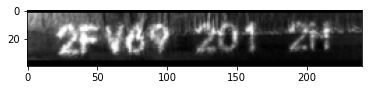

STEP:   7900 TRAIN loss BCE: 0.05165, Accuracy 0.99089
STEP:   8000 TRAIN loss BCE: 0.05623, Accuracy 0.98513
STEP:   8100 TRAIN loss BCE: 0.05718, Accuracy 0.98619
STEP:   8200 TRAIN loss BCE: 0.05441, Accuracy 0.98708
==================== EPOCH: 21 ====================
VALIDATION loss BCE: 0.03716, Accuracy 0.99375
True


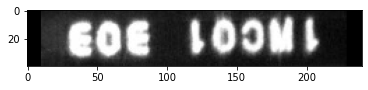

True


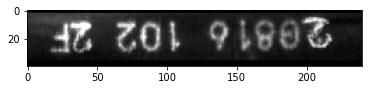

False


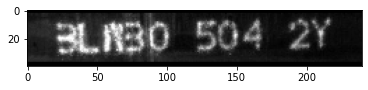

False


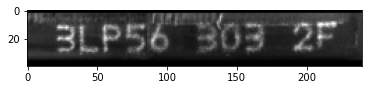

False


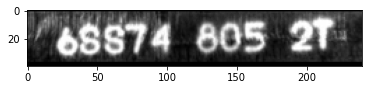

True


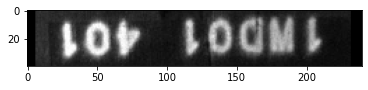

True


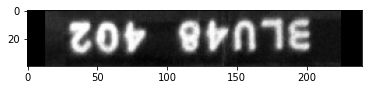

False


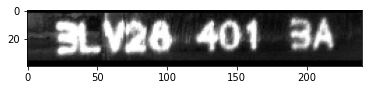

STEP:   8300 TRAIN loss BCE: 0.05242, Accuracy 0.98724
STEP:   8400 TRAIN loss BCE: 0.05484, Accuracy 0.98763
STEP:   8500 TRAIN loss BCE: 0.05057, Accuracy 0.98845
STEP:   8600 TRAIN loss BCE: 0.05468, Accuracy 0.98702
==================== EPOCH: 22 ====================
VALIDATION loss BCE: 0.04074, Accuracy 0.98784
False


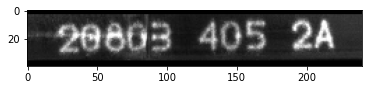

False


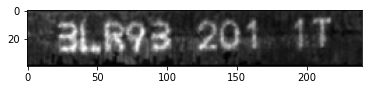

False


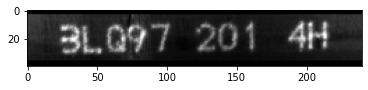

True


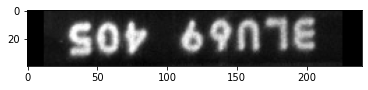

True


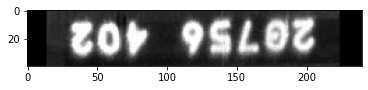

True


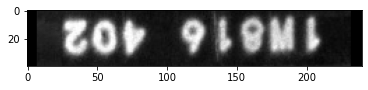

True


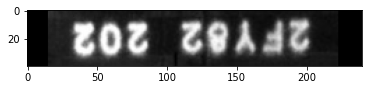

True


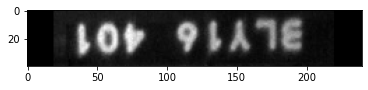

STEP:   8700 TRAIN loss BCE: 0.05813, Accuracy 0.98775
STEP:   8800 TRAIN loss BCE: 0.05091, Accuracy 0.98886
STEP:   8900 TRAIN loss BCE: 0.05680, Accuracy 0.98677
STEP:   9000 TRAIN loss BCE: 0.05482, Accuracy 0.98738
==================== EPOCH: 23 ====================
VALIDATION loss BCE: 0.04078, Accuracy 0.99219
False


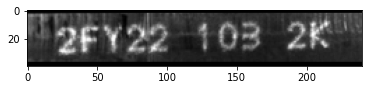

False


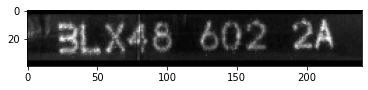

False


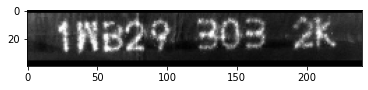

False


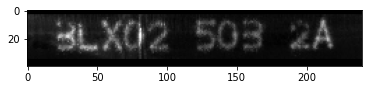

False


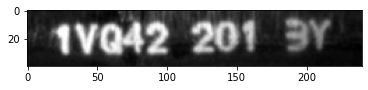

False


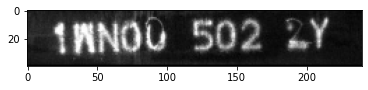

False


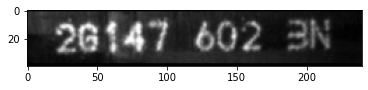

False


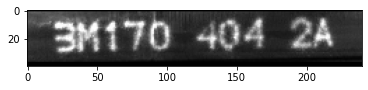

STEP:   9100 TRAIN loss BCE: 0.04868, Accuracy 0.98958
STEP:   9200 TRAIN loss BCE: 0.05096, Accuracy 0.98744
STEP:   9300 TRAIN loss BCE: 0.05913, Accuracy 0.98526
==================== EPOCH: 24 ====================
VALIDATION loss BCE: 0.03887, Accuracy 0.99375
False


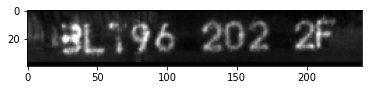

True


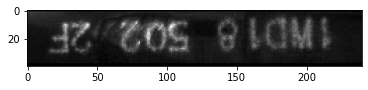

False


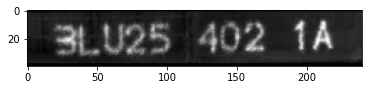

False


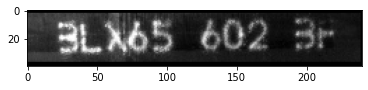

False


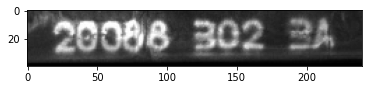

True


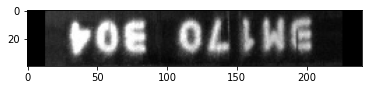

False


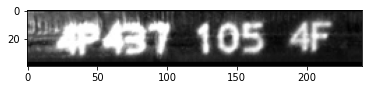

True


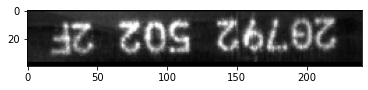

STEP:   9400 TRAIN loss BCE: 0.03914, Accuracy 0.99349
STEP:   9500 TRAIN loss BCE: 0.05357, Accuracy 0.98967
STEP:   9600 TRAIN loss BCE: 0.05543, Accuracy 0.98786
STEP:   9700 TRAIN loss BCE: 0.05088, Accuracy 0.98891
==================== EPOCH: 25 ====================
VALIDATION loss BCE: 0.03403, Accuracy 0.99531
False


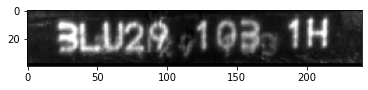

False


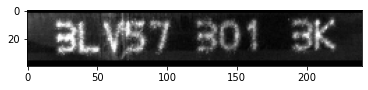

True


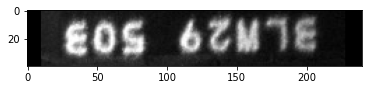

False


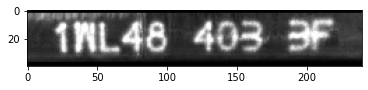

False


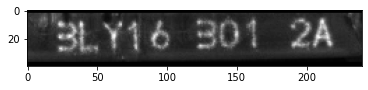

False


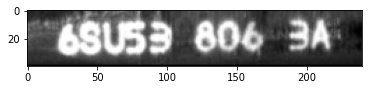

True


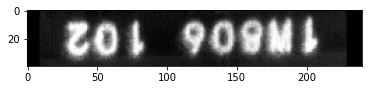

False


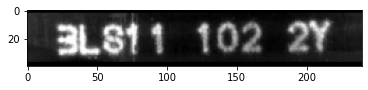

STEP:   9800 TRAIN loss BCE: 0.05419, Accuracy 0.98980
STEP:   9900 TRAIN loss BCE: 0.05387, Accuracy 0.98846
STEP:  10000 TRAIN loss BCE: 0.05216, Accuracy 0.98820
STEP:  10100 TRAIN loss BCE: 0.05126, Accuracy 0.98809
==================== EPOCH: 26 ====================
VALIDATION loss BCE: 0.04330, Accuracy 0.98906
True


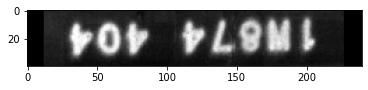

True


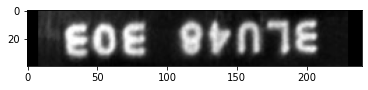

False


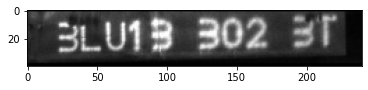

False


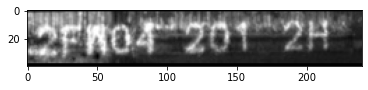

False


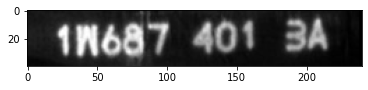

False


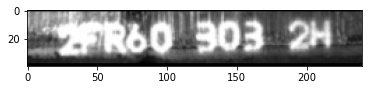

False


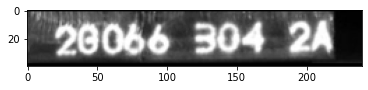

False


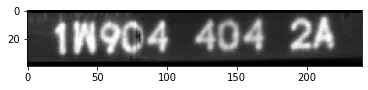

STEP:  10200 TRAIN loss BCE: 0.05368, Accuracy 0.98691
STEP:  10300 TRAIN loss BCE: 0.04838, Accuracy 0.98797
STEP:  10400 TRAIN loss BCE: 0.05235, Accuracy 0.98734
STEP:  10500 TRAIN loss BCE: 0.05108, Accuracy 0.98772
==================== EPOCH: 27 ====================
VALIDATION loss BCE: 0.04037, Accuracy 0.99063
False


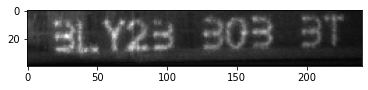

False


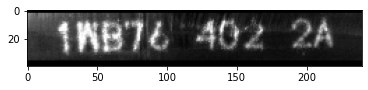

True


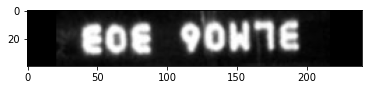

True


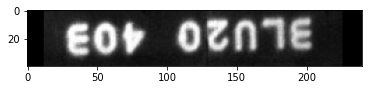

False


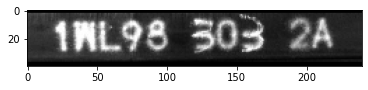

False


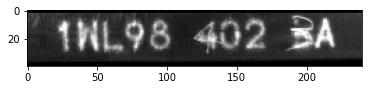

False


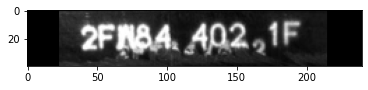

False


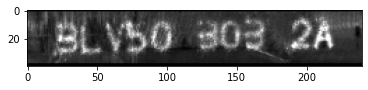

STEP:  10600 TRAIN loss BCE: 0.04811, Accuracy 0.98832
STEP:  10700 TRAIN loss BCE: 0.05821, Accuracy 0.98602
STEP:  10800 TRAIN loss BCE: 0.05773, Accuracy 0.98641
==================== EPOCH: 28 ====================
VALIDATION loss BCE: 0.03918, Accuracy 0.99375
True


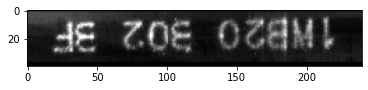

True


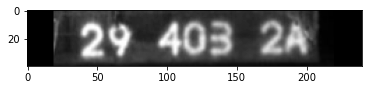

True


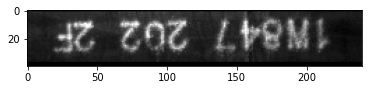

True


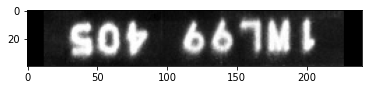

True


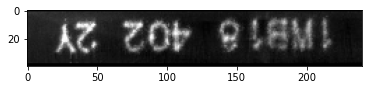

False


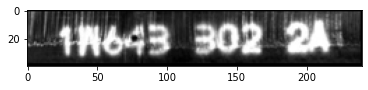

False


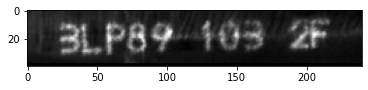

False


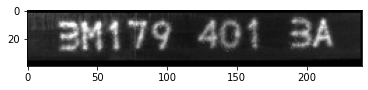

STEP:  10900 TRAIN loss BCE: 0.05052, Accuracy 0.98698
STEP:  11000 TRAIN loss BCE: 0.04970, Accuracy 0.98916
STEP:  11100 TRAIN loss BCE: 0.04455, Accuracy 0.98954
STEP:  11200 TRAIN loss BCE: 0.04705, Accuracy 0.98910
==================== EPOCH: 29 ====================
VALIDATION loss BCE: 0.02748, Accuracy 0.99531
True


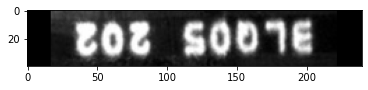

False


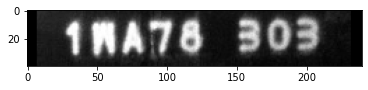

False


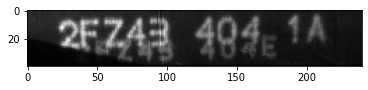

False


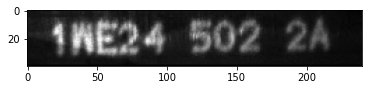

False


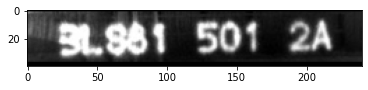

False


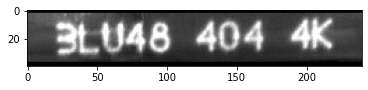

False


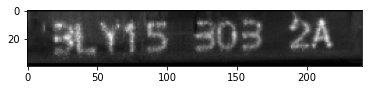

False


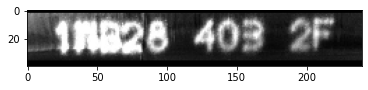

STEP:  11300 TRAIN loss BCE: 0.05746, Accuracy 0.98597
STEP:  11400 TRAIN loss BCE: 0.04910, Accuracy 0.98888
STEP:  11500 TRAIN loss BCE: 0.05035, Accuracy 0.98833
STEP:  11600 TRAIN loss BCE: 0.04908, Accuracy 0.98890
==================== EPOCH: 30 ====================
VALIDATION loss BCE: 0.05115, Accuracy 0.99063
False


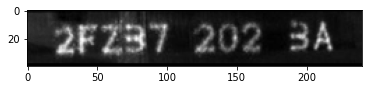

True


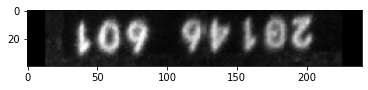

False


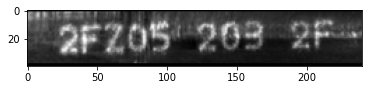

True


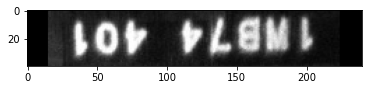

True


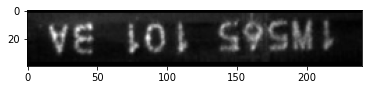

False


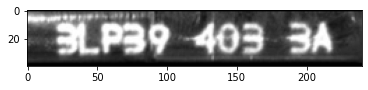

False


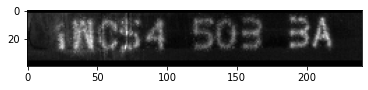

True


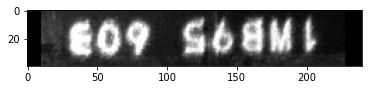

STEP:  11700 TRAIN loss BCE: 0.05261, Accuracy 0.98902
STEP:  11800 TRAIN loss BCE: 0.04909, Accuracy 0.98922
STEP:  11900 TRAIN loss BCE: 0.05019, Accuracy 0.98962
STEP:  12000 TRAIN loss BCE: 0.05302, Accuracy 0.98864
==================== EPOCH: 31 ====================
VALIDATION loss BCE: 0.03917, Accuracy 0.99375
True


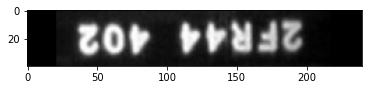

False


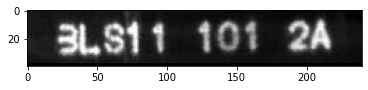

False


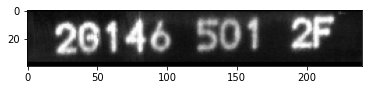

False


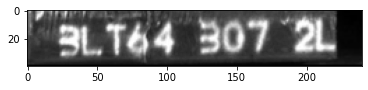

False


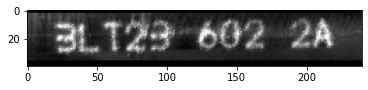

True


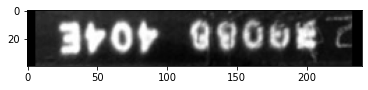

False


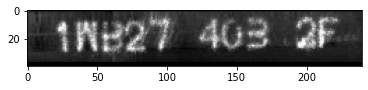

True


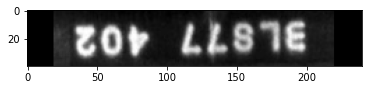

STEP:  12100 TRAIN loss BCE: 0.04502, Accuracy 0.99085
STEP:  12200 TRAIN loss BCE: 0.05306, Accuracy 0.98932
STEP:  12300 TRAIN loss BCE: 0.04835, Accuracy 0.99028
==================== EPOCH: 32 ====================
VALIDATION loss BCE: 0.02888, Accuracy 0.99375
False


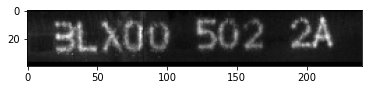

False


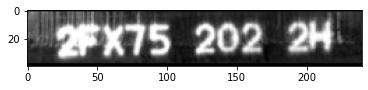

False


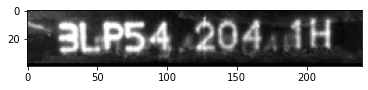

False


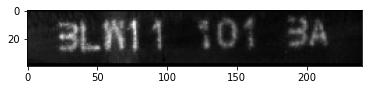

False


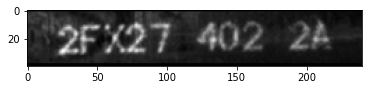

False


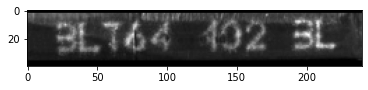

False


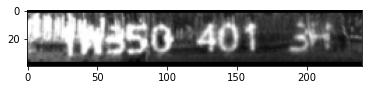

False


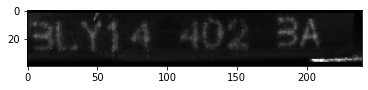

STEP:  12400 TRAIN loss BCE: 0.06554, Accuracy 0.98438
STEP:  12500 TRAIN loss BCE: 0.05069, Accuracy 0.98841
STEP:  12600 TRAIN loss BCE: 0.04574, Accuracy 0.98996
STEP:  12700 TRAIN loss BCE: 0.04979, Accuracy 0.98891
==================== EPOCH: 33 ====================
VALIDATION loss BCE: 0.03422, Accuracy 0.99219
False


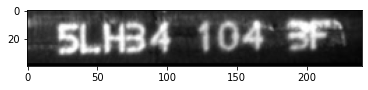

False


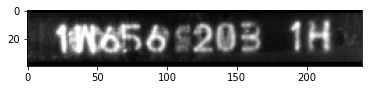

False


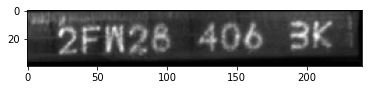

False


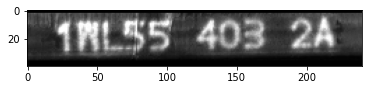

False


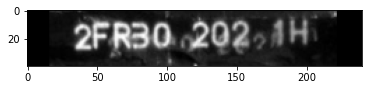

False


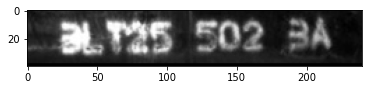

True


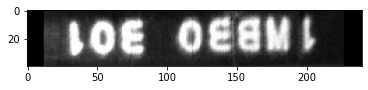

True


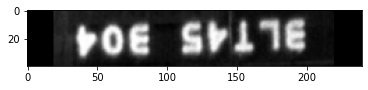

STEP:  12800 TRAIN loss BCE: 0.04702, Accuracy 0.99171


KeyboardInterrupt: 

In [11]:
%run train.py